In [8]:
import pandas as pd

In [9]:
csv_path = '/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/1.preprocessing/entire_remove_outlier.csv'    # 여기에 absolute path
# CSV 읽기
df = pd.read_csv(
    csv_path,
    header=0,        # 첫 줄을 컬럼명으로 사용,  # 인덱스 컬럼으로 id 지정
    encoding='utf-8-sig'
)

# estimated_occupancy_l365d

In [13]:
import time
import json
import pandas as pd
import requests

import geopandas as gpd
from shapely.geometry import Point

# ─────────────────────────────────────────────────────────────────────────────
# 0) 원본 df, poi_tags, 그리고 bbox 계산
  # latitude, longitude 칼럼이 있어야 함

poi_tags = {
    'transport': {
        'amenity': ['bus_station','taxi'],
        'railway': ['station']
    },
    'infrastructure': {
        'amenity': ['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism': ['viewpoint','museum','attraction'],
        'leisure': ['park']
    }
}

pad = 0.01
minx, maxx = df.longitude.min()-pad, df.longitude.max()+pad
miny, maxy = df.latitude.min()-pad, df.latitude.max()+pad

# ─────────────────────────────────────────────────────────────────────────────
# 1) 한 번에 bbox 내 모든 POI 내려받기 (Overpass bbox 쿼리)
OVERPASS_URL = "http://overpass-api.de/api/interpreter"
# build filters for bbox query
filters = ""
for grp in poi_tags.values():
    for key, vals in grp.items():
        for v in vals:
            filters += f'node["{key}"="{v}"]({miny},{minx},{maxy},{maxx});\n'

# full query
query = f"""
[out:json][timeout:180];
(
{filters}
);
out body;
"""

resp = requests.post(OVERPASS_URL, data={'data': query}, timeout=(5,300))
resp.raise_for_status()
data = resp.json().get('elements', [])

# ─────────────────────────────────────────────────────────────────────────────
# 2) GeoDataFrame 생성
pois = pd.DataFrame([
    {
      'lon': el['lon'],
      'lat': el['lat'],
      **el.get('tags',{})
    }
    for el in data
    if el['type']=='node' and 'lon' in el
])
gdf_pois = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(pois.lon, pois.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 원본 좌표도 GeoDataFrame
gdf_pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

sindex = gdf_pois.sindex

# ─────────────────────────────────────────────────────────────────────────────
# 3) 그룹별 카운트 함수
def count_group(pt, grp_map, radius=1000):
    buf = pt.buffer(radius)
    candidates = gdf_pois.iloc[list(sindex.intersection(buf.bounds))]
    cnt = 0
    for key, vals in grp_map.items():
        cnt += candidates[candidates[key].isin(vals)].shape[0]
    return cnt

# 4) 각 포인트별 count, df에 붙이기
for grp, tags in poi_tags.items():
    df[f"{grp}_count"] = [
        count_group(pt, tags, radius=1000)
        for pt in gdf_pts.geometry
    ]

# 5) 결과 확인
print(df[['transport_count','infrastructure_count','tourism_count']].head())


   transport_count  infrastructure_count  tourism_count
0                7                    78              1
1                3                    79              4
2                4                    34              2
3                7                   117              1
4               15                   335              3


In [14]:
df

,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,structure_encoded,log_price,room_new_type,transport_count,infrastructure_count,tourism_count
0,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,...,False,False,True,False,23,5.303305,mid,7,78,1
1,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,...,False,False,True,False,8,4.418841,upper-mid,3,79,4
2,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,...,True,False,False,False,14,4.941642,low-mid,4,34,2
3,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,...,False,False,True,False,23,4.875197,mid,7,117,1
4,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,...,False,False,True,False,23,4.941642,mid,15,335,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015,"New York, NY",NaN,NaN,...,False,False,True,False,23,4.290459,mid,4,58,4
20556,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022,"New York, NY",Are you tired of the tedious and time-consumin...,within an hour,...,False,False,True,False,23,4.077537,mid,4,27,1
20557,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015,"Hawthorne, NJ",NaN,within an hour,...,True,False,False,False,23,5.703782,mid,8,276,6
20558,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021,"New York, NY","At Boomerang, we believe in the idea ""you get ...",within an hour,...,True,False,False,False,23,5.303305,mid,19,340,9


In [17]:
# 위데이터 넣어서 구하기

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1) 데이터 불러오기 & 피처/타깃 설정
TARGET = "estimated_occupancy_l365d"
features = [  # 앞서 선정한 피처 리스트
 'log_price',
 'instant_bookable',
 'availability_90',
 'host_listings_count',
 'is_long_term',
 'is_activate',
 'amenities_cnt',
 'accommodates',
 'bath_score_mul',
 'number_of_reviews',
 'review_scores_rating',
 'name_length_group',
 'description_length_group',
 'neighborhood_overview_exists',
 'host_about_length_group',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_response_rate_score',
 'host_acceptance_rate_score',
 'host_location_ny',
 'host_location_boolean',
 'town_encoded',
 'structure_encoded',
 'transport_count','infrastructure_count','tourism_count']
X = df[features].fillna(0)
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 하이퍼파라미터 분포 설정
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, cv=3, scoring="neg_mean_squared_error", random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

print("✔ Best RF params:", rf_search.best_params_)
print("✔ Best XGB params:", xgb_search.best_params_)

# 5) 검증 성능 (튜닝 후)
def eval_model(model, X_t, y_t):
    y_pred = model.predict(X_t)
    return root_mean_squared_error(y_t, y_pred), mean_absolute_error(y_t, y_pred), r2_score(y_t, y_pred)

rf_rmse, rf_mae, rf_r2 = eval_model(best_rf, X_test, y_test)
xgb_rmse, xgb_mae, xgb_r2 = eval_model(best_xgb, X_test, y_test)
print(f"RF tuned  RMSE={rf_rmse:.2f}, MAE={rf_mae:.2f}, R2 Score={rf_r2:.2f}")
print(f"XGB tuned RMSE={xgb_rmse:.2f}, MAE={xgb_mae:.2f}, R2 Score={xgb_r2:.2f}")

# 6) Ensemble: Voting Regressor
voting = VotingRegressor([("rf", best_rf), ("xgb", best_xgb)])
voting.fit(X_train, y_train)
v_rmse, v_mae, v_r2 = eval_model(voting, X_test, y_test)
print(f"Voting   RMSE={v_rmse:.2f}, MAE={v_mae:.2f}, R2 Score={v_r2:.2f}")

# 7) Ensemble: Stacking Regressor
stack = StackingRegressor(
    estimators=[("rf", best_rf), ("xgb", best_xgb)],
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)
stack.fit(X_train, y_train)
s_rmse, s_mae, s_r2 = eval_model(stack, X_test, y_test)
print(f"Stacking RMSE={s_rmse:.2f}, MAE={s_mae:.2f}, R2 Score={s_r2:.2f}")

print(rf_r2, xgb_r2, v_r2, s_r2)


✔ Best RF params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
✔ Best XGB params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RF tuned  RMSE=47.52, MAE=27.96, R2 Score=0.76
XGB tuned RMSE=48.22, MAE=29.64, R2 Score=0.76
Voting   RMSE=47.45, MAE=28.60, R2 Score=0.76
Stacking RMSE=47.37, MAE=28.41, R2 Score=0.76
0.7622214564636092 0.7551865577697754 0.7629192129410981 0.763767642993121


=== Feature Importances ===
last_review                     0.727765
number_of_reviews               0.092650
is_long_term                    0.018145
availability_90                 0.017698
log_price                       0.017110
infrastructure_count            0.015348
amenities_cnt                   0.014607
review_scores_rating            0.013741
host_listings_count             0.012636
town_encoded                    0.011484
host_is_superhost               0.009793
transport_count                 0.009017
tourism_count                   0.007485
structure_encoded               0.005626
accommodates                    0.005595
host_acceptance_rate_score      0.004194
bath_score_mul                  0.002987
host_about_length_group         0.002498
description_length_group        0.002265
neighborhood_overview_exists    0.001920
name_length_group               0.001824
instant_bookable                0.001531
host_location_ny                0.001424
host_location_boolean        

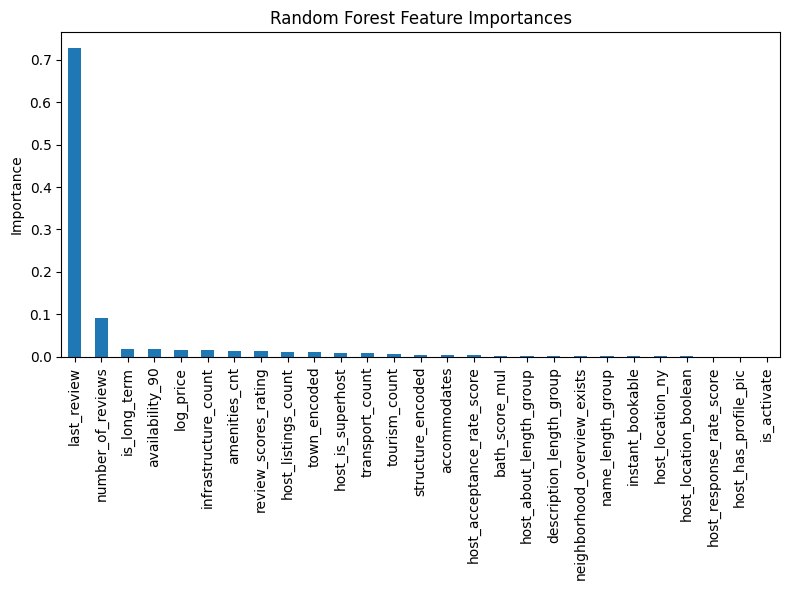


=== Variance Inflation Factors ===
                         feature         VIF
0                          const  362.356465
21         host_location_boolean    3.453173
20              host_location_ny    3.218392
25               transport_count    3.060767
26          infrastructure_count    2.931420
27                 tourism_count    2.596693
24                   last_review    2.139745
1                      log_price    2.061754
6                    is_activate    1.896553
4            host_listings_count    1.798021
8                   accommodates    1.565500
7                  amenities_cnt    1.431068
5                   is_long_term    1.424242
2               instant_bookable    1.346871
9                 bath_score_mul    1.323351
14  neighborhood_overview_exists    1.303468
19    host_acceptance_rate_score    1.266308
15       host_about_length_group    1.261875
16             host_is_superhost    1.238740
10             number_of_reviews    1.220832
12             name

In [16]:
import pandas as pd
import numpy as np

# 1) 필요한 라이브러리 임포트
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2) 피처/타깃 정의 (df, TARGET, features 는 이미 정의된 상태라 가정)
# 예시:
# TARGET = "estimated_occupancy_l365d"
# features = base_feats + ['transport_count','infrastructure_count','tourism_count']

X = df[features].fillna(0)
y = df[TARGET]

# 3) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 랜덤포레스트 모델 학습 (피처임포턴스용)
rf = RandomForestRegressor(
    n_estimators=500, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

# 5) 피처임포턴스 출력
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)
print("=== Feature Importances ===")
print(importances)

# (옵션) 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
importances.plot.bar()
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 6) VIF 계산을 위해 상수항 추가
X_train_sm = sm.add_constant(X_train)

# 7) VIF 계산
vif = pd.DataFrame({
    'feature': X_train_sm.columns,
    'VIF': [
        variance_inflation_factor(X_train_sm.values, i)
        for i in range(X_train_sm.shape[1])
    ]
}).sort_values('VIF', ascending=False)
print("\n=== Variance Inflation Factors ===")
print(vif)


In [25]:
df[features]

,log_price,instant_bookable,availability_90,host_listings_count,is_long_term,is_activate,amenities_cnt,accommodates,bath_score_mul,number_of_reviews,...,host_has_profile_pic,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,town_encoded,structure_encoded,transport_score,infrastructure_score,tourism_score
0,5.303305,0,87,1.0,1,0,7,1,0.5,9,...,1,4,4,1,1,159,23,0.269231,0.142596,0.037037
1,4.418841,0,0,1.0,1,1,32,2,1.0,102,...,1,4,4,1,1,62,8,0.115385,0.144424,0.148148
2,4.941642,0,25,1.0,0,1,47,2,1.0,241,...,1,4,4,1,1,96,14,0.153846,0.062157,0.074074
3,4.875197,0,38,2.0,0,1,29,2,0.5,274,...,1,4,4,1,1,214,23,0.269231,0.213894,0.037037
4,4.941642,0,90,2.0,1,0,14,2,1.0,44,...,1,4,4,0,1,97,23,0.576923,0.612431,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,4.290459,0,83,1.0,1,0,5,1,0.5,0,...,1,4,4,1,1,96,23,0.153846,0.106033,0.148148
20556,4.077537,0,88,24.0,1,0,7,2,1.0,0,...,1,4,4,1,1,12,23,0.153846,0.049360,0.037037
20557,5.703782,0,39,619.0,1,0,7,5,2.0,0,...,1,4,4,0,1,114,23,0.307692,0.504570,0.222222
20558,5.303305,1,90,26.0,1,0,30,4,1.0,0,...,1,4,4,1,1,191,23,0.730769,0.621572,0.333333


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

# 1) 데이터 & 피처 정의
TARGET = "estimated_occupancy_l365d"
features = [
    'log_price','instant_bookable','availability_90','host_listings_count',
    'is_long_term','is_activate','amenities_cnt','accommodates','bath_score_mul',
    'number_of_reviews','review_scores_rating','name_length_group',
    'description_length_group','neighborhood_overview_exists',
    'host_about_length_group','host_is_superhost','host_has_profile_pic',
    'host_response_rate_score','host_acceptance_rate_score',
    'host_location_ny','host_location_boolean','town_encoded',
    'structure_encoded',
    'transport_score','infrastructure_score','tourism_score'
]

X = df[features]
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 범주형으로 처리할 칼럼 리스트 (필요에 맞게 조정)
cat_features = [
    'instant_bookable','is_long_term','is_activate',
    'neighborhood_overview_exists','host_is_superhost',
    'host_has_profile_pic','host_location_ny','host_location_boolean',
    'town_encoded','structure_encoded','name_length_group',
    'description_length_group'
]

# 4) 모델 정의 & 학습
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test)
)

# 5) 예측 & 평가
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"CatBoost RMSE={rmse:.2f}, R²={r2:.3f}")


0:	learn: 94.1199690	test: 94.2206127	best: 94.2206127 (0)	total: 6.46ms	remaining: 6.46s
100:	learn: 50.7545183	test: 51.0823888	best: 51.0823888 (100)	total: 342ms	remaining: 3.04s
200:	learn: 48.9631129	test: 50.1202599	best: 50.1202599 (200)	total: 665ms	remaining: 2.64s
300:	learn: 47.4722409	test: 49.4670197	best: 49.4652078 (299)	total: 990ms	remaining: 2.3s
400:	learn: 46.3697171	test: 49.0651664	best: 49.0651664 (400)	total: 1.32s	remaining: 1.97s
500:	learn: 45.5462666	test: 48.8622549	best: 48.8604947 (498)	total: 1.64s	remaining: 1.63s
600:	learn: 44.8009645	test: 48.7107497	best: 48.7091672 (597)	total: 1.96s	remaining: 1.3s
700:	learn: 44.1075698	test: 48.6167813	best: 48.6153629 (697)	total: 2.29s	remaining: 978ms
800:	learn: 43.5128832	test: 48.5317583	best: 48.5317583 (800)	total: 2.6s	remaining: 646ms
900:	learn: 42.9559174	test: 48.4882724	best: 48.4873693 (895)	total: 2.9s	remaining: 319ms
999:	learn: 42.4050166	test: 48.4508089	best: 48.4507732 (997)	total: 3.21s	r

In [ ]:
df['booking_proxy'] = 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

# 1) 데이터 & 피처 정의
TARGET = "estimated_occupancy_l365d"
features = [
    'log_price','instant_bookable','availability_90','host_listings_count',
    'is_long_term','is_activate','amenities_cnt','accommodates','bath_score_mul',
    'number_of_reviews','review_scores_rating','name_length_group',
    'description_length_group','neighborhood_overview_exists',
    'host_about_length_group','host_is_superhost','host_has_profile_pic',
    'host_response_rate_score','host_acceptance_rate_score',
    'host_location_ny','host_location_boolean','town_encoded',
    'structure_encoded',
    'transport_count','infrastructure_count','tourism_count'
]

X = df[features]
y = df[TARGET]

# 2) 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) 범주형으로 처리할 칼럼 리스트 (필요에 맞게 조정)
cat_features = [
    'instant_bookable','is_long_term','is_activate',
    'neighborhood_overview_exists','host_is_superhost',
    'host_has_profile_pic','host_location_ny','host_location_boolean',
    'town_encoded','structure_encoded','name_length_group',
    'description_length_group'
]

# 4) 모델 정의 & 학습
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test)
)

# 5) 예측 & 평가
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"CatBoost RMSE={rmse:.2f}, R²={r2:.3f}")


# reserved_days_365


In [29]:
df

,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,room_type_Shared room,structure_encoded,log_price,room_new_type,transport_count,infrastructure_count,tourism_count,transport_score,infrastructure_score,tourism_score
0,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,...,False,23,5.303305,mid,7,78,1,0.269231,0.142596,0.037037
1,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,...,False,8,4.418841,upper-mid,3,79,4,0.115385,0.144424,0.148148
2,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,...,False,14,4.941642,low-mid,4,34,2,0.153846,0.062157,0.074074
3,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,...,False,23,4.875197,mid,7,117,1,0.269231,0.213894,0.037037
4,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,...,False,23,4.941642,mid,15,335,3,0.576923,0.612431,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20555,city scrape,Beautiful 1-Bed Apt in Harlem!,Welcome to your temporary home in the vibrant ...,NaN,40019013,Cecilia,2015,"New York, NY",NaN,NaN,...,False,23,4.290459,mid,4,58,4,0.153846,0.106033,0.148148
20556,city scrape,Private Room w/ Ensuite Bath H,Stylish Private Rooms w/ En-Suite Baths in Bro...,NaN,483056418,Kristina,2022,"New York, NY",Are you tired of the tedious and time-consumin...,within an hour,...,False,23,4.077537,mid,4,27,1,0.153846,0.049360,0.037037
20557,city scrape,2 Bedroom on East Side,Located in the Murray Hill area and occupies a...,NaN,30283594,Global Luxury Suites,2015,"Hawthorne, NJ",NaN,within an hour,...,False,23,5.703782,mid,8,276,6,0.307692,0.504570,0.222222
20558,city scrape,Stylish 2Bd near Bryant Park,Enjoy everything the city has to offer while l...,NaN,407304997,Boomerang,2021,"New York, NY","At Boomerang, we believe in the idea ""you get ...",within an hour,...,False,23,5.303305,mid,19,340,9,0.730769,0.621572,0.333333


In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# 1) 새로운 “가용예상일수” 컬럼
df['avail_annual'] = 365 - df['availability_90'] * 4

# 2) 블렌딩 함수
def blended_forecast(df, alpha, beta):
    return alpha * df['estimated_occupancy_l365d'] + beta * df['avail_annual']

# 3) 손실(예: RMSE) 계산용
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 4) α,β 탐색 (그리드서치 예시)
best = {'alpha':None, 'beta':None, 'rmse': float('inf')}
for alpha in [0.2,0.4,0.6,0.8,1.0]:
    for beta in [0.2,0.4,0.6,0.8,1.0]:
        y_pred = blended_forecast(df, alpha, beta)
        score = rmse(df['true_booking_365'], y_pred)  # 실제값이 있으면
        if score < best['rmse']:
            best.update(alpha=alpha, beta=beta, rmse=score)

print("최적 블렌딩:", best)


KeyError: 'true_booking_365'

In [31]:
df['estimated_occupancy_l365d']

0          0
1          0
2        255
3        154
4          0
        ... 
20555      0
20556      0
20557      0
20558      0
20559      0
Name: estimated_occupancy_l365d, Length: 20560, dtype: int64

In [33]:
df['reserved_days_future'] = 365 - (df['availability_60'] * 6)

In [35]:
df[['estimated_occupancy_l365d', 'reserved_days_future']].describe()

,estimated_occupancy_l365d,reserved_days_future
count,20560.000000,20560.000000
mean,74.498103,148.089202
std,97.367183,141.791983
min,0.000000,5.000000
25%,0.000000,11.000000
50%,0.000000,107.000000
75%,120.000000,293.000000
max,255.000000,365.000000


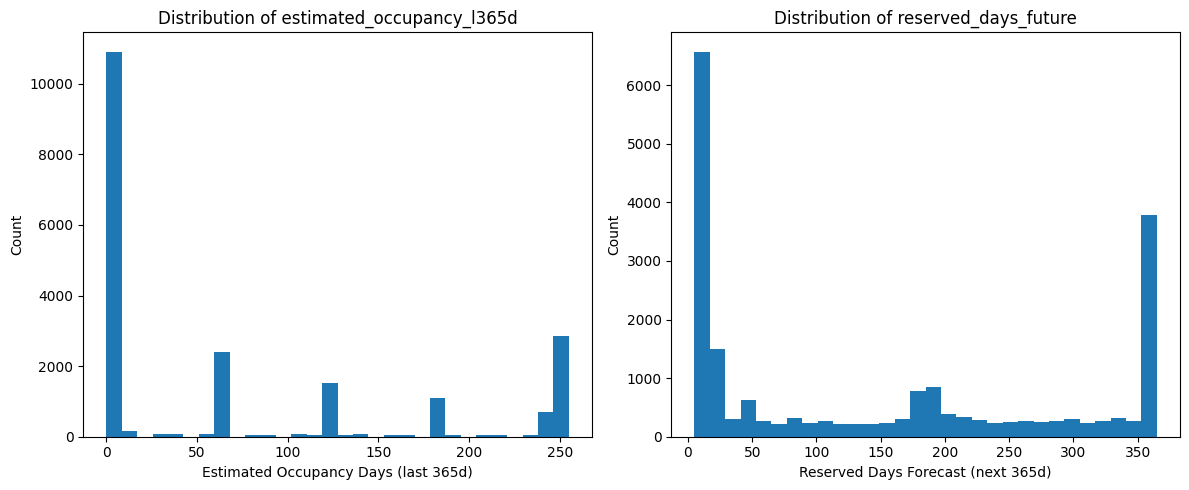

/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_88021/1710697411.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


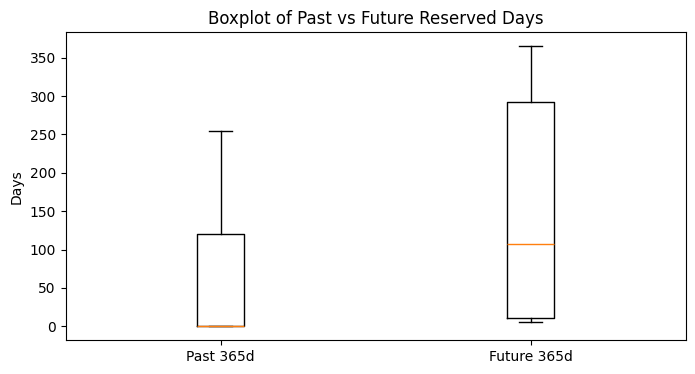

In [36]:
import matplotlib.pyplot as plt

# 1) 히스토그램 그리기
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['estimated_occupancy_l365d'], bins=30)
plt.title('Distribution of estimated_occupancy_l365d')
plt.xlabel('Estimated Occupancy Days (last 365d)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df['reserved_days_future'], bins=30)
plt.title('Distribution of reserved_days_future')
plt.xlabel('Reserved Days Forecast (next 365d)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# 2) 박스플롯 그리기
plt.figure(figsize=(8, 4))
plt.boxplot(
    [df['estimated_occupancy_l365d'], df['reserved_days_future']],
    labels=['Past 365d', 'Future 365d']
)
plt.title('Boxplot of Past vs Future Reserved Days')
plt.ylabel('Days')
plt.show()


In [37]:
df['past365_log']   = np.log1p(df['estimated_occupancy_l365d'])
df['future365_log'] = np.log1p(df['reserved_days_future'])


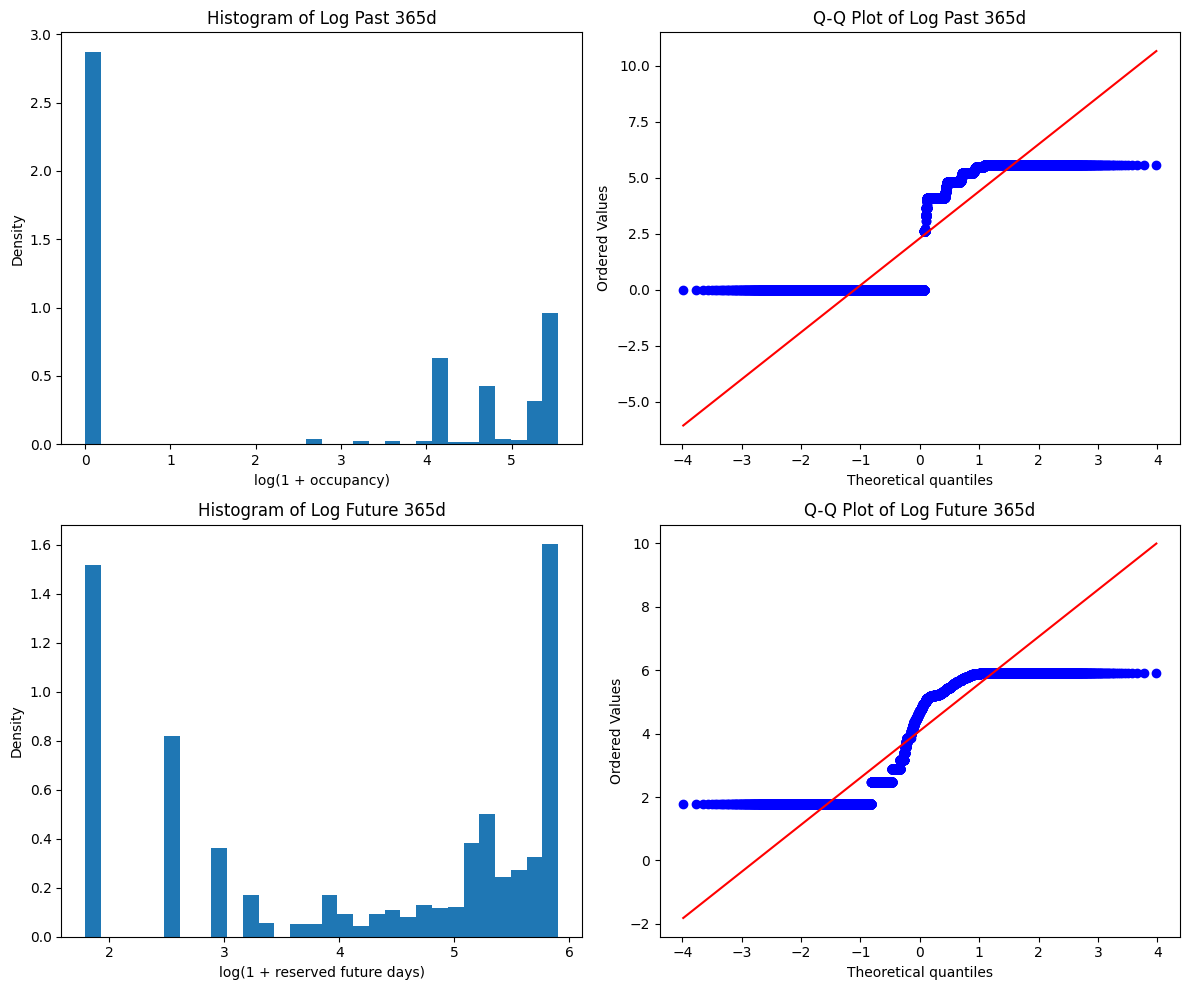

In [39]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Ensure log columns are present
if 'past365_log' not in df.columns:
    df['past365_log'] = np.log1p(df['estimated_occupancy_l365d'])
if 'future365_log' not in df.columns:
    df['future365_log'] = np.log1p(df['reserved_days_future'])

# Create subplots for histogram and Q-Q plots
grid = plt.figure(figsize=(12,10))

# Histogram of past365_log
ax1 = grid.add_subplot(2,2,1)
ax1.hist(df['past365_log'], bins=30, density=True)
ax1.set_title('Histogram of Log Past 365d')
ax1.set_xlabel('log(1 + occupancy)')
ax1.set_ylabel('Density')

# Q-Q plot of past365_log
ax2 = grid.add_subplot(2,2,2)
stats.probplot(df['past365_log'], dist='norm', plot=ax2)
ax2.set_title('Q-Q Plot of Log Past 365d')

# Histogram of future365_log
ax3 = grid.add_subplot(2,2,3)
ax3.hist(df['future365_log'], bins=30, density=True)
ax3.set_title('Histogram of Log Future 365d')
ax3.set_xlabel('log(1 + reserved future days)')
ax3.set_ylabel('Density')

# Q-Q plot of future365_log
ax4 = grid.add_subplot(2,2,4)
stats.probplot(df['future365_log'], dist='norm', plot=ax4)
ax4.set_title('Q-Q Plot of Log Future 365d')

plt.tight_layout()
plt.show()
